In [844]:
#from typing import Match

import numpy as np
import matplotlib
import matplotlib.pyplot as plt # para plots
import itertools


### Gerando nosso Dataset ###

In [845]:

# Função que define a equação diferencial
def EDO_pendulo(t, y):
    theta, d_theta_dt = y
    dd_theta_dt = - (g / L) * np.sin(theta)
    return [d_theta_dt, dd_theta_dt]

def generate_data_set(omega = 1, theta = 0, time_parameters =[] ):
    t_0,t_end,dt = time_parameters    
    # Método de Euler para resolver a EDO
    t_values = np.arange(t_0, t_end, dt)

    theta_values = []
    omega_values = []
    for t in t_values:
        theta_values.append(theta)
        omega_values.append(omega)
        
        # Método de Euler
        dtheta_dt, domega_dt = EDO_pendulo(t, [theta, omega])
        theta += dtheta_dt * dt
        omega += domega_dt * dt

    # Converter o deslocamento angular para coordenadas x-y
    x_values = L * np.sin(theta_values)
    y_values = -L * np.cos(theta_values)
    return [x_values,y_values]

def plot_Pendulum(data):
    x_values, y_values = data 
    # Plotagem
    plt.plot(x_values, y_values)
    plt.xlabel('x (t)')
    plt.ylabel('y (t)')
    plt.title('Movimento do Pêndulo Simples')
    plt.grid(True)
    plt.axis('equal')
    plt.show()



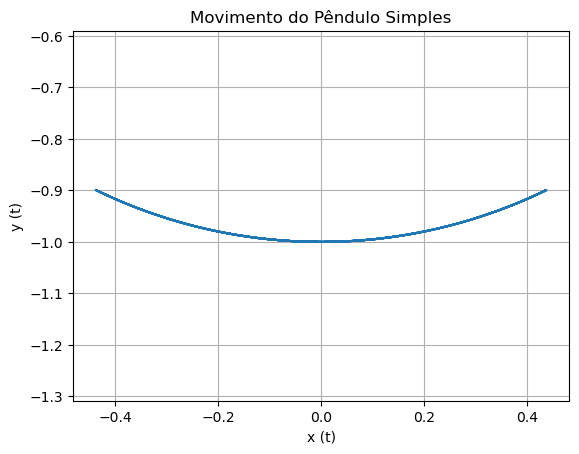

In [846]:

# Constantes
global g, L, phi, omega_0
g = 9.81  # m/s^2, aceleração devido à gravidade
L = 1.0   # m, comprimento do pêndulo
phi = np.pi / 10  # Ângulo inicial em radianos
omega_0 = 1.0        # Velocidade angular inicial

# Parâmetros de tempo
N=30000 # Numero de pontos
t_0 = 0.0            # Tempo inicial
t_end = 6.0         # Tempo final
dt = t_end/N            # Tamanho do passo de tempo
time_parameters = [t_0,t_end,dt]

# Condições iniciais
theta = phi 
omega = omega_0

data = generate_data_set(omega, theta, time_parameters)
plot_Pendulum(data)


### Usando o perceptron para adquirir informação sobre o sistema 


Suponha agora que só há o data set como entrada, ou seja, não temmos mais informação do que a imagem plotada acima. Vamos usar o perceptron para verificar se conseguimos adquirir informação sobre a fase e frequencia do nosso pendulo apenas alimentando a rede com $(x,y)$ . 

A ideia é o perceptron ter como input $(x,y)$ , e como output $\sin(theta)$. Idealmente, $\theta$ tem a forma

 $x*w1 + y*w_2 + b = \theta$ 

idealmente, como somente $x,y$ mudam com o tempo $t$, então, podemos associar 

$x*w1 + y*w_2 = \omega*t,  \quad \text{e} \quad b = \varphi_0$ 

In [847]:

# definindo funções do perceptron

def perceptron(y_in = [], w=[], b=[]) :
    z_in = np.dot(w,y_in) #+ b
    z_out1 = activation(z_in)
    z_out = np.sin(z_out1 +b)
    z_out_y = -np.sqrt(1-z_out**2)
    dif = dif_activation(z_in)
    return [[z_out,z_out_y],dif] #[np.concatenate((z_out,z_out_y)), dif ]

def activation(z=0):
    return np.sin(z)
                
# definindo derivada da função custo (será util para o treino)
def dif_activation(z):
    #return np.cos(z)
    return np.cos(np.sin(z)+b)*np.cos(z)

#def sigmoid (z=0):
#    return 1/(1 + np.exp(-z))

def create_RandomWeights_perceptron(Ns =[]):
    ''' cria pesos e bias aleatorios para o perceptron.
    '''
    w = np.random.uniform(low=-2,high=2,size=(2,))
    b = np.random.uniform(low=np.pi/20,high=np.pi/8,size=(1))
    return [w,b]

def Loss_function(z_out, z_real):
    return sum(sum((z_out- z_real)**2)+ ((b-phi)**2)[0])



#### Alguns resultados com inicialização aleatória e sem treinamento

In [848]:
# preparando os pesos e bias
W, b = create_RandomWeights_perceptron([])
global b

# verificando um output para incialização aleatoria
x_0, y_0 = data[0][0], data[1][0]
z_out,dif = perceptron([x_0,y_0], W,b)

z_real = np.array(x_0,y_0)
loss = Loss_function(z_out,z_real)#[x_0,y_0])


#vamos ver alguns valores
print(f'z_out = sin(w1*x_0 + w2*y_0 +b) =  {z_out[0]}')
print(f'z_out_y = -cos(1*x_0 + w2*y_0 +b) = {z_out[1]}')
print(f'x,y esperados = {x_0}, {y_0} \n')
print(f'Loss = {loss}\n')
print(f'W = {W}')
print(f'b = {b}')

z_out = sin(w1*x_0 + w2*y_0 +b) =  [0.08891898]
z_out_y = -cos(1*x_0 + w2*y_0 +b) = [-0.99603886]
x,y esperados = 0.3090169943749474, -0.9510565162951535 

Loss = 1.755514450817266

W = [-0.71618807 -0.0609004 ]
b = [0.25170507]


#### Definindo funções de treinamento (backpropagation)

In [849]:
def backpropagation_perceptron(delta,w,df):
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( np.dot(delta,np.transpose(w))*df )

def treinamento_perceptron_1Passo(data, W,b, Epochs, lr):
    # verificando um output para incialização aleatoria
    loss = np.zeros(Epochs)
    x_0, y_0 = data[0][0], data[1][0]
    z_out,dif = perceptron([x_0,y_0], W,b)
    loss[0] = Loss_function(z_out,[x_0,y_0])
    
    # calculando passo do gradiente
    grad = (z_out - [x_0,y_0]) 
    delta = np.dot(grad,W)*dif
    grad_step = np.transpose(delta*[x_0,y_0])
    
    # atualizando valores
    W = W - lr*grad_step
    b = b - lr*delta

    x_0, y_0 = data[0][0], data[1][0]
    z_out,dif = perceptron([x_0,y_0], W,b)
    loss[1] = Loss_function(z_out,[x_0,y_0])
    return loss

def treinamento_perceptron(data, W,b, Epochs, lr,batch_size = 100):
    # verificando um output para incialização aleatoria
    loss = np.zeros(Epochs)
    x_values, y_values = np.zeros((2,Epochs))
    for j in range(Epochs):
        x_values[j], y_values[j] = data[0][j], data[1][j]
    for j in range(Epochs):
        x,y = np.zeros((2,batch_size))
        rand_j = np.arange(0,Epochs, np.floor(Epochs/batch_size), dtype= int)
        np.random.shuffle(rand_j)
        k=0
        # construindo batch
        for r in iter(rand_j):
            x[k], y[k] = x_values[r], y_values[r]
            k +=1
        z_real = np.array((x,y))
        z_out,dif = perceptron([x,y], W,b)

        loss[j] = Loss_function(z_out,z_real)
        # calculando passo do gradiente
        grad = (z_out - z_real) 
        delta = np.dot(W,grad)*dif
        grad_step = np.mean(np.transpose(delta*[x,y]),axis=0)
        if j%(Epochs/3) ==0:
            lr = lr/2

        # atualizando valores
        W = W - lr*grad_step
        #b = b - lr*delta
        if j%(Epochs/10) ==0:
            print(f'loss = {loss[j]} for iteration = {j} , lr = {lr}')
    return loss
    



In [850]:
# preparando os pesos e bias iniciais
global data2
W, b = create_RandomWeights_perceptron([])
b = np.array([phi])

# verificando um output para incialização aleatoria
x_0, y_0 = data[0][0], data[1][0]
z_out= perceptron([x_0,y_0], W,b)[0]

#loss = Loss_function(z_out,[x_0,y_0])

Epochs =30000
loss = treinamento_perceptron(data, W,b, Epochs, lr=0.02, batch_size= 100)

data2 = np.zeros((2,N))
for j in range(N):
    data2[0,j], data2[1,j]  = perceptron([data[0][j],data[1][j]], W,b)[0]
#plot_Pendulum(data2)

z_out= perceptron([x_0,y_0], W,b)[0]

#vamos ver alguns valores
print(f'\nx_out = sin(w1*x_0 + w2*y_0 +b) =  {z_out[0]}')
print(f'y_out = -cos(1*x_0 + w2*y_0 +b) = {z_out[1]}')
print(f'x,y esperados = {x_0}, {y_0} \n')
print(f'Loss = {loss[-1]}\n')
print(f'W = {W}')
print(f'b = {b} = phi? = {phi}\n')
print(f'omega = {np.dot(W,[data[0][0], data[1][0]])} ')

loss = 4.579110648788458 for iteration = 0 , lr = 0.01
loss = 0.2737369132696838 for iteration = 3000 , lr = 0.01
loss = 0.07247471127513955 for iteration = 6000 , lr = 0.01
loss = 0.0664574338298767 for iteration = 9000 , lr = 0.01
loss = 0.06611571739530792 for iteration = 12000 , lr = 0.005
loss = 0.06604893134230992 for iteration = 15000 , lr = 0.005
loss = 0.06602549683712204 for iteration = 18000 , lr = 0.005
loss = 0.06601796676837512 for iteration = 21000 , lr = 0.0025
loss = 0.06601571710837971 for iteration = 24000 , lr = 0.0025
loss = 0.06601436243776014 for iteration = 27000 , lr = 0.0025

x_out = sin(w1*x_0 + w2*y_0 +b) =  [0.06169099]
y_out = -cos(1*x_0 + w2*y_0 +b) = [-0.9980953]
x,y esperados = 0.3090169943749474, -0.9510565162951535 

Loss = 0.0660135464069854

W = [0.38358341 0.39295625]
b = [0.31415927] = phi? = 0.3141592653589793

omega = -0.25518981038207145 


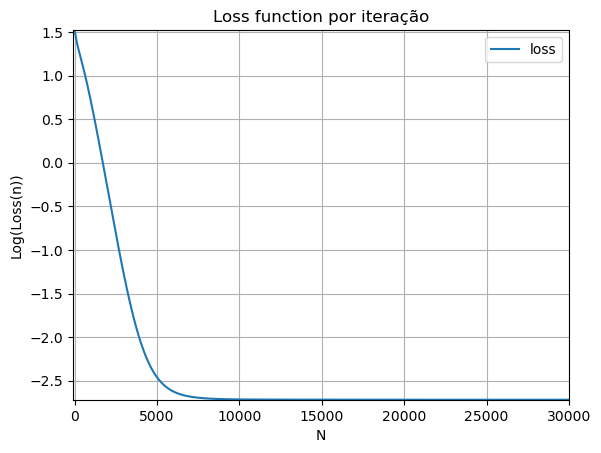

In [851]:
ax = plt.gca()
ax.set(ylim=(min(np.log(loss)), max(np.log(loss))), xlim=(-100, N))
plt.plot(range(N), np.log(loss), label = 'loss')
plt.xlabel('N')
plt.ylabel('Log(Loss(n))')
plt.title('Loss function por iteração')
plt.grid(True)
plt.legend()
plt.show()

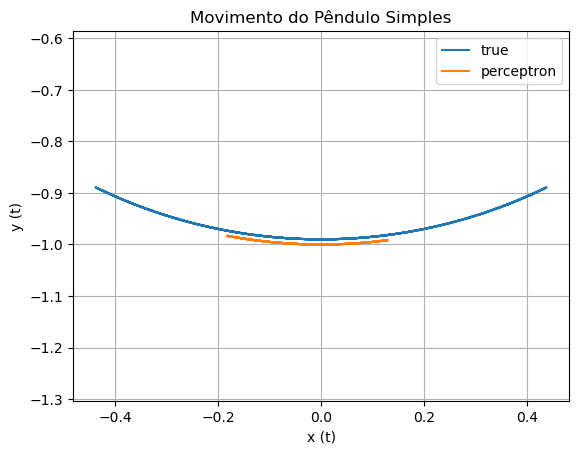

In [852]:
x_values, y_values = data 
x_values2, y_values2 = data2 
# Plotagem
plt.plot(x_values, y_values+0.01, label = 'true')
plt.xlabel('x (t)')
plt.ylabel('y (t)')
plt.title('Movimento do Pêndulo Simples')
plt.grid(True)
plt.axis('equal')
plt.plot(x_values2, y_values2, label = 'perceptron')
plt.legend()
plt.show()